In [1]:
import os

from pyspark import SparkContext


def readFile(filename):
    """
    Return an RDD containing the data of filename.
    Each example (row) of the file corresponds to one RDD record.
    Each record of the RDD is a tuple (X,y). “X” is an array containing the 11
    features (float number) of an example
    “y” is the 12th column of an example (integer 0/1)
    """

    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    sc = SparkContext.getOrCreate()
    data = sc.textFile(parent_directory + "/" + filename)
    processed_data = data.map(lambda line: line.split(",")).map(
        lambda cols: ([float(x) for x in cols[:11]], float(cols[11]))
    )
    return processed_data


In [2]:
import numpy as np
from pyspark import SparkContext


def normalize(RDD_Xy):
    sc = SparkContext.getOrCreate()

    number_of_samples = RDD_Xy.count()

    # Function to compute sum and sum of squares for each feature
    def compute_sum_and_squares(record):
        X, _ = record
        return (np.array(X), np.array(X) ** 2)

    # Aggregate the sum and sum of squares for each feature, and count the examples
    sum_squares_count = RDD_Xy.map(compute_sum_and_squares).reduce(
        lambda a, b: (a[0] + b[0], a[1] + b[1])
    )

    # Calculate the mean and variance for each feature
    mean = sum_squares_count[0] / number_of_samples
    variance = (sum_squares_count[1] / number_of_samples) - mean**2
    std_dev = np.sqrt(variance)

    # Replace zeros in standard deviation with ones to avoid division by zero
    std_dev[std_dev == 0] = 1

    # Broadcast the mean and std_dev to all the nodes
    broadcast_mean = sc.broadcast(mean)
    broadcast_std_dev = sc.broadcast(std_dev)

    # Function to normalize features
    def normalize_features(record):
        X, y = record
        X_normalized = (X - broadcast_mean.value) / broadcast_std_dev.value
        return (X_normalized, y)

    # Normalize each feature and return the new RDD
    return RDD_Xy.map(normalize_features)


In [3]:
import random


def transform(RDD_Xy, num_blocks):
    # Function to assign a random index to each record
    def add_index(record):
        # Randomly select an index between 0 and num_blocks - 1
        index = random.randint(0, num_blocks - 1)
        # Return a new record with the index added
        return (record, index)

    # Map each record in the RDD to include a random fold index
    RDD_tranformed = RDD_Xy.map(add_index)
    return RDD_tranformed


In [4]:
def get_block_data(data_cv, block_numb):
    """
    Splits the input RDD into two RDDs based on the index value.

    :param data_cv: An RDD where each row is a list of size 11, y, and index.
    :param block_numb: The block number to split the RDD.
    :return: A tuple of two RDDs (tr_data, test_data).
    """

    # Split the data into two RDDs based on the index value

    def filter_block_train(record):
        if record[1] != block_numb:
            return [record[0]]
        else:
            return []

    def filter_block_test(record):
        if record[1] == block_numb:
            return [record[0]]
        else:
            return []

    tr_data = data_cv.flatMap(filter_block_train)
    test_data = data_cv.flatMap(filter_block_test)

    return tr_data, test_data


In [5]:
import numpy as np
from pyspark import SparkContext


def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    sc = SparkContext.getOrCreate()

    # Number of features (assuming all records have the same number of features)
    k = len(RDD_Xy.first()[0])
    m = RDD_Xy.count()  # Total number of examples

    np.random.seed(0)  # For reproducibility
    w = np.random.rand(k)  # Weight vector
    b = np.random.rand()  # Bias term

    for i in range(iterations):
        # Broadcast weights and bias
        broadcast_w = sc.broadcast(w)
        broadcast_b = sc.broadcast(b)

        # Compute gradients
        gradients = RDD_Xy.map(
            lambda x: compute_gradients(x, broadcast_w.value, broadcast_b.value, k)
        ).reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))

        # Update weights and bias
        w -= learning_rate * ((1 / m) * gradients[0] + (lambda_reg / k) * w)
        b -= learning_rate * (
            (1 / m) * gradients[1] + ((lambda_reg / (2 * k)) * np.sum(w**2))
        )

        # Optional: Print cost for monitoring (not recommended for large datasets)
        cost = RDD_Xy.map(
            lambda x: compute_cost(x, broadcast_w.value, broadcast_b.value, k)
        ).reduce(lambda x, y: x + y)
        cost = (-1 / m) * cost
        cost += (lambda_reg / (2 * k)) * np.sum(w**2)
        
    return w, b


def compute_gradients(record, w, b, k):
    X, y = record
    z = 0
    for i in range(k):
        z += X[i] * w[i]
    z += b
    y_hat = 1 / (1 + np.exp(-z))
    dw = (y_hat - y) * X
    db = np.sum(y_hat - y)
    return dw, db


def compute_cost(record, w, b, k):
    X, y = record
    z = 0
    for i in range(k):
        z += X[i] * w[i]
    z += b
    y_hat = 1 / (1 + np.exp(-z))
    cost = y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)
    return cost


In [6]:
def accuracy(w, b, RDD_xy):
    prediction_results = RDD_xy.map(
        lambda record: 1 if predict(w, b, record[0]) == record[1] else 0
    )

    # Step 2: Use reduce to sum up the correct predictions
    correctly_classified = prediction_results.reduce(lambda a, b: a + b)

    # Step 4: Calculate accuracy
    accuracy = correctly_classified / RDD_xy.count()
    return accuracy


In [7]:
import numpy as np


def predict(w, b, X):
    # Initialize the sum
    z = 0
    # Iterate over the weights and corresponding features
    for i in range(len(w)):
        z += w[i] * X[i]
        # Add the bias term
    z += b

    # compact way to calculate it z = np.dot(w, X) + b

    # Apply the sigmoid function to get the probability
    p = 1 / (1 + np.exp(-z))
    # Predict the class label (0 or 1) based on the probability
    if p >= 0.5:
        return 1
    else:
        return 0


In [8]:
import os
import sys

import time
import pyspark
import matplotlib.pyplot as plt
from pyspark import SparkContext


if __name__ == "__main__":
    os.environ["PYSPARK_PYTHON"] = sys.executable
    os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

    execution_times = []
    speed_up = []
    for i in [12,15]:
        start_time = time.time()
        number_cores = i
        conf = (
            pyspark.SparkConf()
            .setMaster('local[{}]'.format(number_cores))
        )

        sc = pyspark.SparkContext(conf=conf)
        # read data
        data = readFile("/data/botnet_tot_syn_l.csv")
        # standardize
        data = normalize(data)
    
        num_blocks_cv = 10
        # Shuffle rows and transfrom data
        data_cv = transform(data, num_blocks_cv)
        # optimize performance
        data_cv_cached = data_cv.cache()
    
        accuracies = []
        for i in range(num_blocks_cv):
            tr_data, test_data = get_block_data(data_cv_cached, i)
            # optimize performance
            tr_data_cached = tr_data.cache()
            test_data_cached = test_data.cache()
            weights, bias = train(tr_data_cached, 10, 1.5, 0.05)
            acc = accuracy(weights, bias, test_data_cached)
            accuracies.append(acc)
            print("accuracy:", acc)
            print("------------------------------------------------------")
        avg_acc = 0
        for a in accuracies:
            avg_acc += a
        print("average accuracy:", avg_acc / num_blocks_cv)
        execution_times.append(time.time() - start_time)
        sc.stop()
    num_workers = list(range(1, len(execution_times)+1))


23/12/16 19:31:18 WARN Utils: Your hostname, MacBook-Pro-di-Alessandro-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.152 instead (on interface en0)
23/12/16 19:31:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/16 19:31:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/16 19:31:23 WARN BlockManager: Task 18 already completed, not releasing lock for rdd_5_0
23/12/16 19:31:29 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


accuracy: 0.9324211197703853
------------------------------------------------------


23/12/16 19:31:42 WARN BlockManager: Task 226 already completed, not releasing lock for rdd_31_0


accuracy: 0.9294688010193923
------------------------------------------------------


23/12/16 19:32:00 WARN BlockManager: Task 434 already completed, not releasing lock for rdd_57_0


accuracy: 0.9310310370325959
------------------------------------------------------


23/12/16 19:32:18 WARN BlockManager: Task 642 already completed, not releasing lock for rdd_83_0


accuracy: 0.9312719620616398
------------------------------------------------------


23/12/16 19:32:35 WARN BlockManager: Task 850 already completed, not releasing lock for rdd_109_0


accuracy: 0.9306159329350936
------------------------------------------------------


23/12/16 19:32:53 WARN BlockManager: Task 1058 already completed, not releasing lock for rdd_135_0


accuracy: 0.930727604317192
------------------------------------------------------


23/12/16 19:33:11 WARN BlockManager: Task 1266 already completed, not releasing lock for rdd_161_0


accuracy: 0.9310630070362176
------------------------------------------------------


23/12/16 19:33:28 WARN BlockManager: Task 1474 already completed, not releasing lock for rdd_187_0


accuracy: 0.9307931804302776
------------------------------------------------------


23/12/16 19:33:45 WARN BlockManager: Task 1682 already completed, not releasing lock for rdd_213_0


accuracy: 0.9310925549084275
------------------------------------------------------


23/12/16 19:34:03 WARN BlockManager: Task 1890 already completed, not releasing lock for rdd_239_0


accuracy: 0.9314384117099348
------------------------------------------------------
average accuracy: 0.9309923611221157


23/12/16 19:34:24 WARN BlockManager: Task 18 already completed, not releasing lock for rdd_5_0


accuracy: 0.9316718173661649
------------------------------------------------------


23/12/16 19:34:42 WARN BlockManager: Task 226 already completed, not releasing lock for rdd_31_0


accuracy: 0.9291648404191736
------------------------------------------------------


23/12/16 19:34:59 WARN BlockManager: Task 434 already completed, not releasing lock for rdd_57_0


accuracy: 0.9309044596207267
------------------------------------------------------


23/12/16 19:35:16 WARN BlockManager: Task 642 already completed, not releasing lock for rdd_83_0


accuracy: 0.9315552441953563
------------------------------------------------------


23/12/16 19:35:32 WARN BlockManager: Task 850 already completed, not releasing lock for rdd_109_0


accuracy: 0.9318983874353924
------------------------------------------------------


23/12/16 19:35:49 WARN BlockManager: Task 1058 already completed, not releasing lock for rdd_135_0


accuracy: 0.9288846960588513
------------------------------------------------------


23/12/16 19:36:06 WARN BlockManager: Task 1266 already completed, not releasing lock for rdd_161_0


accuracy: 0.9315750959813149
------------------------------------------------------


23/12/16 19:36:24 WARN BlockManager: Task 1474 already completed, not releasing lock for rdd_187_0


accuracy: 0.9311004114155297
------------------------------------------------------


23/12/16 19:36:41 WARN BlockManager: Task 1682 already completed, not releasing lock for rdd_213_0


accuracy: 0.9325182060567472
------------------------------------------------------


23/12/16 19:36:58 WARN BlockManager: Task 1890 already completed, not releasing lock for rdd_239_0


accuracy: 0.9307073520130631
------------------------------------------------------
average accuracy: 0.9309980510562319


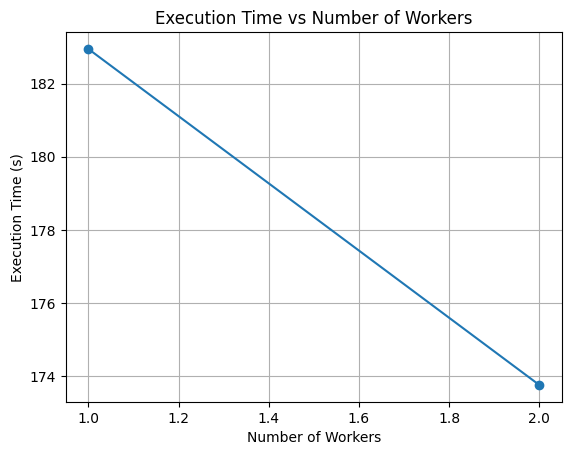

In [9]:
plt.plot(num_workers, execution_times, marker='o', linestyle='-')
plt.xlabel('Number of Workers')  # Label for x-axis
plt.ylabel('Execution Time (s)')  # Label for y-axis
plt.title('Execution Time vs Number of Workers')  # Title for the plot
plt.grid(True)  # Show grid lines
plt.show()

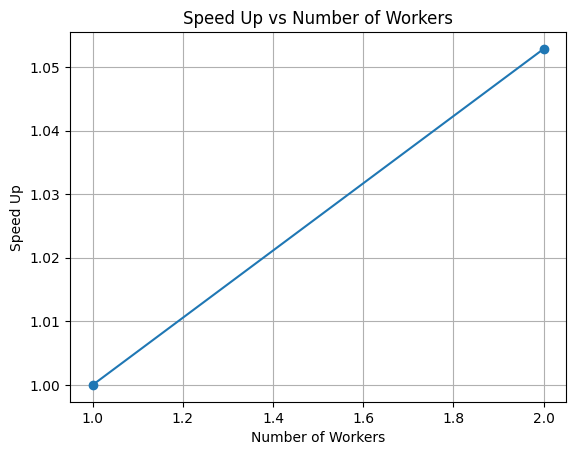

In [10]:
for i in range(0,len(execution_times)):
    speed_up.append(execution_times[0]/execution_times[i])
plt.plot(num_workers, speed_up, marker='o', linestyle='-')
plt.xlabel('Number of Workers')  # Label for x-axis
plt.ylabel('Speed Up')  # Label for y-axis
plt.title('Speed Up vs Number of Workers')  # Title for the plot
plt.grid(True)  # Show grid lines
plt.show()